In [67]:
import numpy as np

import typing 
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [68]:
gpu_device = tf.config.list_physical_devices('GPU')
print(gpu_device)

if gpu_device:
    details = tf.config.experimental.get_device_details(gpu_device[0])
print(details)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
{'device_name': 'GeForce MX130', 'compute_capability': (5, 0)}


# Download the dataset

In [69]:
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', 
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [70]:
text = path_to_file.read_text(encoding='utf-8')
print(len(text))
print(text[:30])

7919056
Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go


In [71]:
lines = text.splitlines()
pairs = [line.split('\t') for line in lines] # get eng-spa paris
context_raw = np.array([c for _, c in pairs])
target_raw = np.array([t for t, _ in pairs])

In [72]:
print(context_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [73]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


# Prepare the dataset

In [74]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

In [75]:
train_val_ratio = 0.8
# Uniformly distributed random number array with the length of target_raw
is_train = np.random.uniform(size=(len(target_raw),)) 
print(is_train)
# Pick numbers less than the train_test_ratio
# to get the array of bool values for determining 
# whether include the item in the train set
is_train = is_train < train_val_ratio
print(is_train)

[0.21538624 0.65951409 0.88538127 ... 0.28147711 0.00999456 0.7494605 ]
[ True  True False ...  True  True  True]


In [76]:
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [77]:
for sample_cs, sample_ts in train_raw.take(1):
    print(sample_cs[:5])
    print()
    print(sample_ts[:5])
    print()
    break

tf.Tensor(
[b'\xc2\xbfCual es tu serie de televisi\xc3\xb3n favorita?'
 b'Tom no quiere comer.' b'Te voy a hacer da\xc3\xb1o.'
 b'Por favor env\xc3\xademe su foto.'
 b'Tom tiene que ver a un mont\xc3\xb3n de gente ma\xc3\xb1ana por la ma\xc3\xb1ana.'], shape=(5,), dtype=string)

tf.Tensor(
[b"What's your favorite TV series?" b"Tom doesn't want to eat."
 b"I'm going to hurt you." b'Please send me your picture.'
 b'Tom has a lot of people to see tomorrow morning.'], shape=(5,), dtype=string)



# Text Preprocessing

In [78]:
sample_text =tf.constant('¿Todavía está en casa?')
print(sample_text.numpy())
print(sample_text.numpy().decode())

temp_text = tf_text.normalize_utf8(sample_text, 'NFKD')
print(temp_text.numpy())
temp_text = tf.strings.lower(temp_text)
print(temp_text.numpy())
temp_text = tf.strings.regex_replace(temp_text, '[^ a-z.?!,¿]', '')
print(temp_text.numpy())
temp_text = tf.strings.regex_replace(temp_text, '[.?!,¿]', r' \0 ')
print(temp_text.numpy())
temp_text = tf.strings.strip(temp_text)
print(temp_text.numpy())
temp_text = tf.strings.join(['[SOS]', temp_text, '[EOS]'], separator=' ')
print(temp_text.numpy())

print(temp_text.numpy().decode())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
¿Todavía está en casa?
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'
b'\xc2\xbftodavi\xcc\x81a esta\xcc\x81 en casa?'
b'\xc2\xbftodavia esta en casa?'
b' \xc2\xbf todavia esta en casa ? '
b'\xc2\xbf todavia esta en casa ?'
b'[SOS] \xc2\xbf todavia esta en casa ? [EOS]'
[SOS] ¿ todavia esta en casa ? [EOS]


### 1. Standardization

In [79]:
def text_standardize(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    # Lower all letter in the string
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)
    # Add a start and end token to each sentence
    text = tf.strings.join(['[SOS]', text, '[EOS]'], separator=' ')
    
    return text

In [80]:
print(sample_text.numpy().decode())
print(text_standardize(sample_text).numpy().decode())

¿Todavía está en casa?
[SOS] ¿ todavia esta en casa ? [EOS]


### 2. Create a word index and reverse word index dictionaries

In [81]:
max_vocab_size = 5000

In [82]:
# Spanish TextVectorization layer
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=text_standardize,
    max_tokens=max_vocab_size,
    ragged=True
)
context_text_processor.adapt(train_raw.map(lambda context, target: context))
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[SOS]', '[EOS]', '.', 'que', 'de', 'el', 'a', 'no']

In [83]:
# English TextVectorization layer
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=text_standardize,
    max_tokens=max_vocab_size,
    ragged=True
)
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[SOS]', '[EOS]', '.', 'the', 'i', 'to', 'you', 'tom']

In [84]:
sample_cs_tokens = context_text_processor(sample_cs)
sample_cs_tokens[:5, :]

<tf.RaggedTensor [[2, 13, 155, 15, 36, 1, 6, 333, 933, 12, 3], [2, 10, 9, 110, 154, 4, 3],
 [2, 30, 109, 8, 54, 979, 4, 3], [2, 21, 67, 1, 26, 577, 4, 3],
 [2, 10, 44, 5, 117, 8, 16, 653, 6, 157, 82, 21, 11, 82, 4, 3]]>

In [85]:
context_vocab = np.array(context_text_processor.get_vocabulary())
for i in range(len(sample_cs[:5])):
    tokens = context_vocab[sample_cs_tokens[i].numpy()]
    print(' '.join(tokens))

[SOS] ¿ cual es tu [UNK] de television favorita ? [EOS]
[SOS] tom no quiere comer . [EOS]
[SOS] te voy a hacer dano . [EOS]
[SOS] por favor [UNK] su foto . [EOS]
[SOS] tom tiene que ver a un monton de gente manana por la manana . [EOS]


Text(0.5, 1.0, 'Mask')

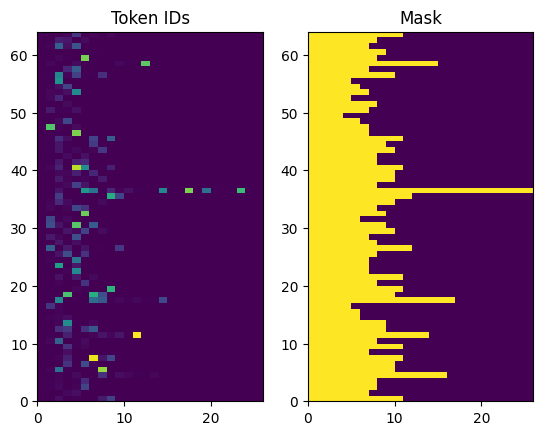

In [86]:
# The returned token IDs are zero-padded
plt.subplot(1, 2, 1)
plt.pcolormesh(sample_cs_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(sample_cs_tokens.to_tensor() != 0)
plt.title('Mask')

### 3. Pad each sentence to a maximum length

In [87]:
# In this example, bidirectional GRU will be used for model training
# Thus, the target are seperated into two set, the forward and backward
# denote as target_in, target_out
# The difference between target_in and target_out is that
# they are shifted by one step relative to eachothe
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:, 1:].to_tensor()
    
    return (context, targ_in), targ_out

In [88]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = train_raw.map(process_text, tf.data.AUTOTUNE)

In [89]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :15].numpy()) 
  print()
  print(ex_tar_in[0, :15].numpy()) 
  print(ex_tar_out[0, :15].numpy())

[  2  11 179  17  20   1   4   3   0   0   0   0   0   0   0]

[   2    5  228   12 3314    4    0    0    0    0    0    0    0    0]
[   5  228   12 3314    4    3    0    0    0    0    0    0    0    0]


# The Encode-decoder 

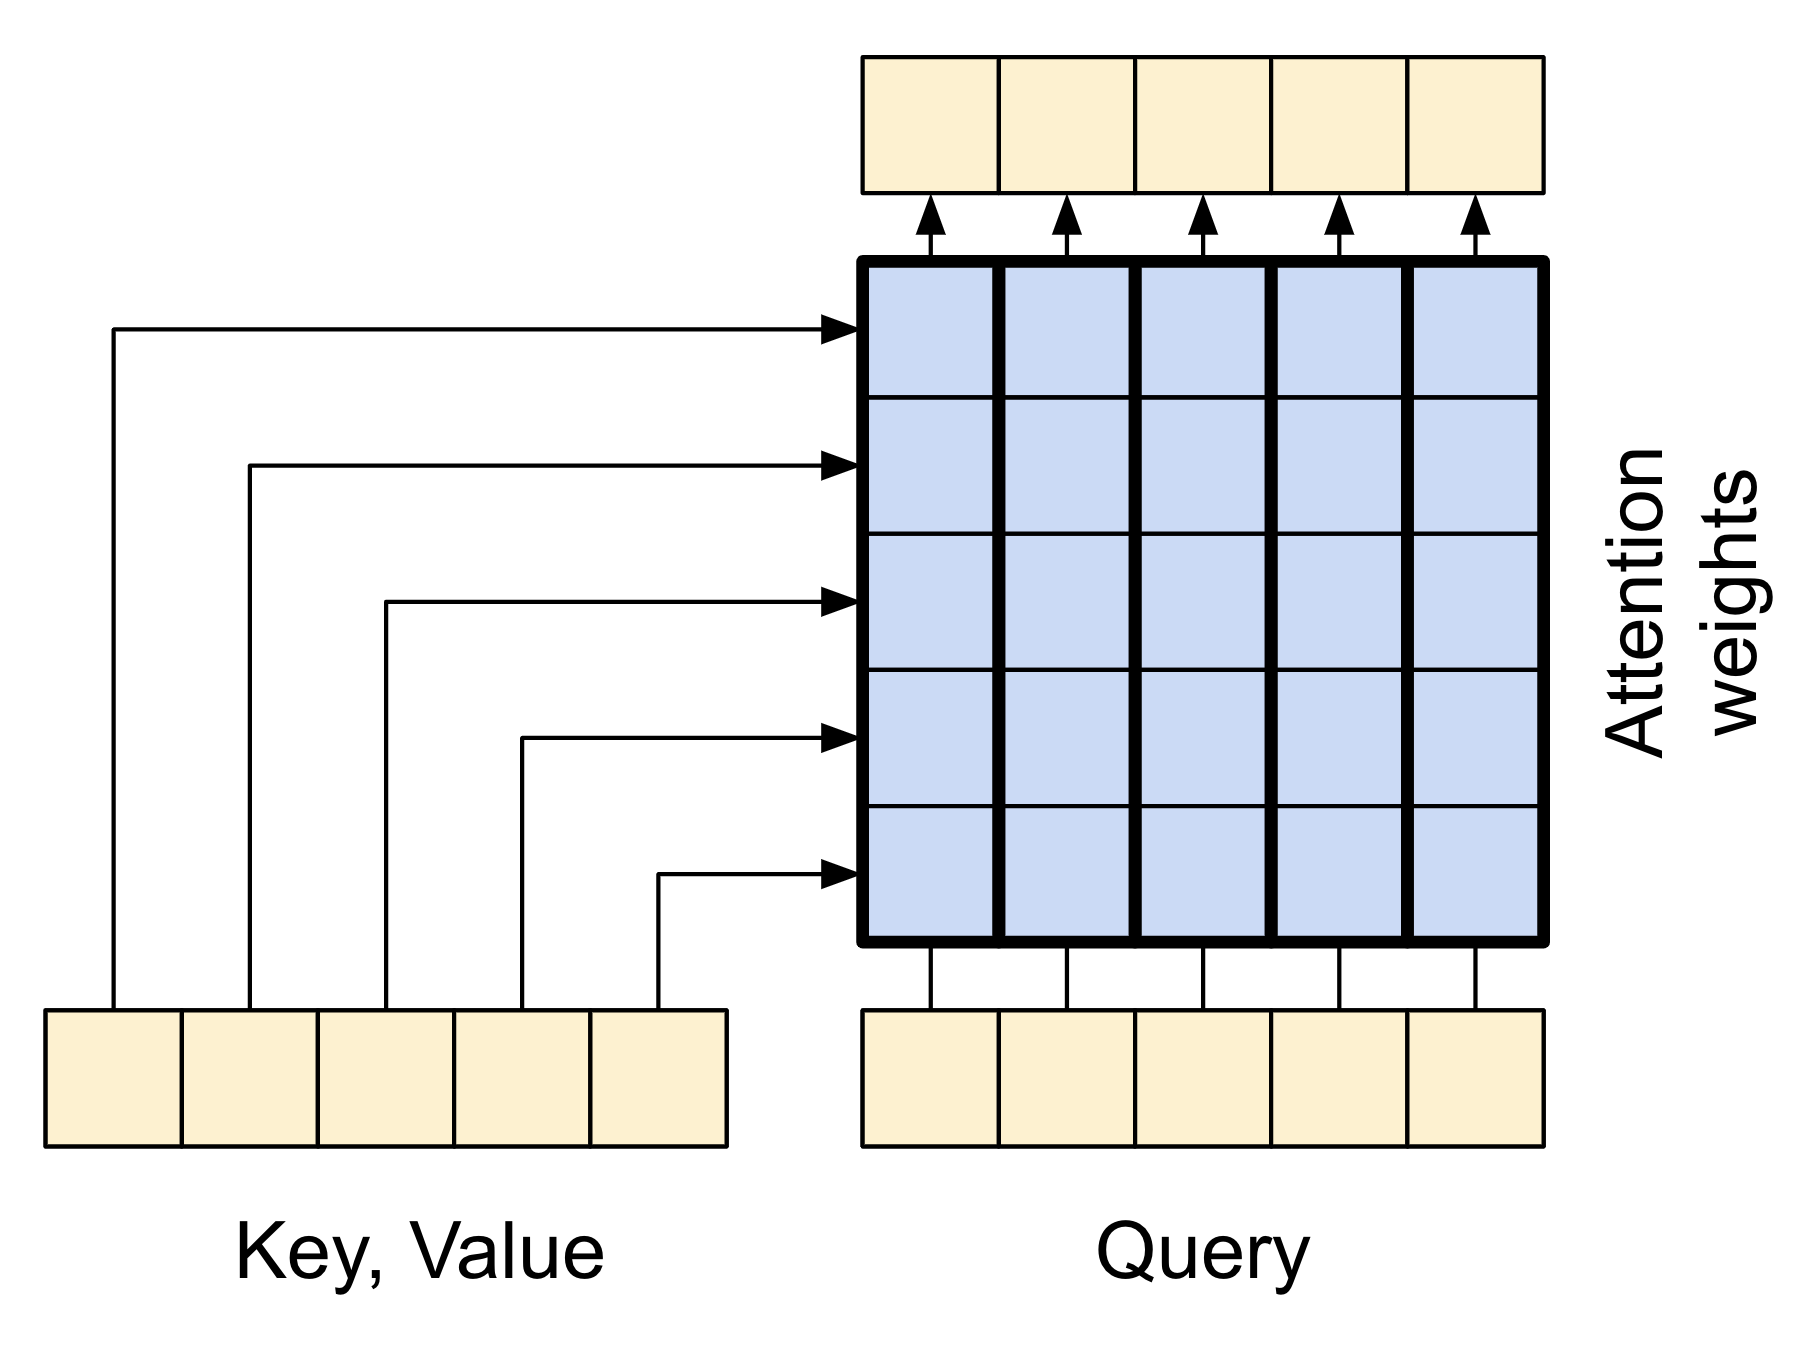

In [90]:
from IPython import display

display.Image('imgs/RNN+attention.png')

In [91]:
UNITS = 256 # Word embedding dimension: a word is represented as a 256-D vector

In [92]:
context_text_processor.vocabulary_size()

5000

In [93]:
# This class is used to check shapes
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

### 1. The encoder: Bidirectional GRU

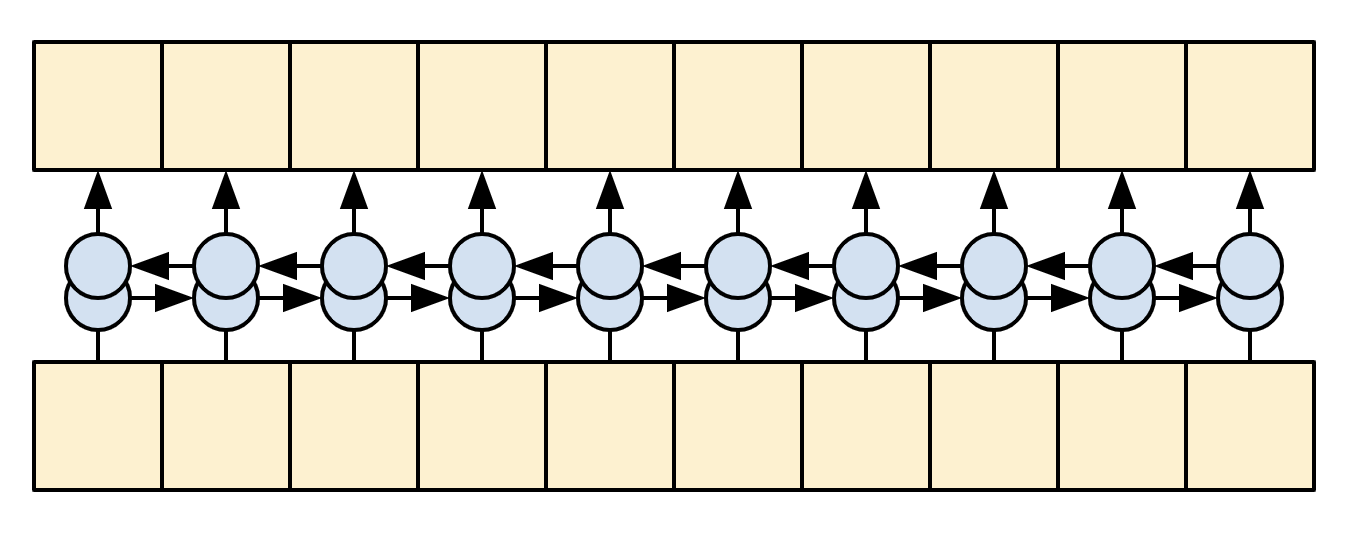

In [94]:
display.Image('imgs/EncoderBidirectionalRNN.png')

In [95]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units
        
        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=units,
            mask_zero=True)
        
        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(
                units=units,
                return_sequences=True, # Return the sequence and state
                recurrent_initializer='glorot_uniform'
            )
        )
    
    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')
        
        # The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')
        
        # The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')
        
        # Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [96]:
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

In [97]:
print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 256)


### 2. The attention layer

In [98]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
    def call(self, x, context):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')
        
        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True
        )

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')
        
        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores
        
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [99]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 16, 256)
Target sequence, shape (batch, t, units): (64, 14, 256)
Attention result, shape (batch, t, units): (64, 14, 256)
Attention weights, shape (batch, t, s):    (64, 14, 16)


In [100]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

Text(0.5, 1.0, 'Mask')

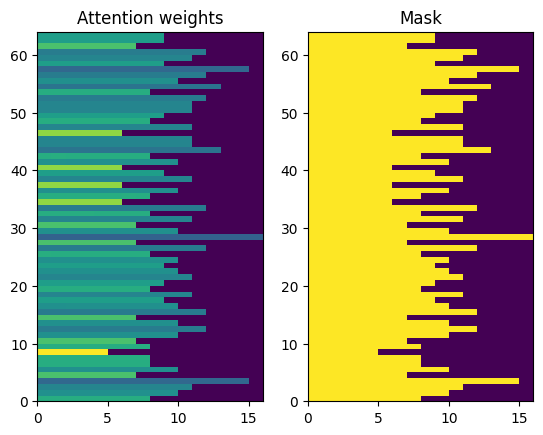

In [101]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask')

### 3. The decoder: Unidirectional GRU

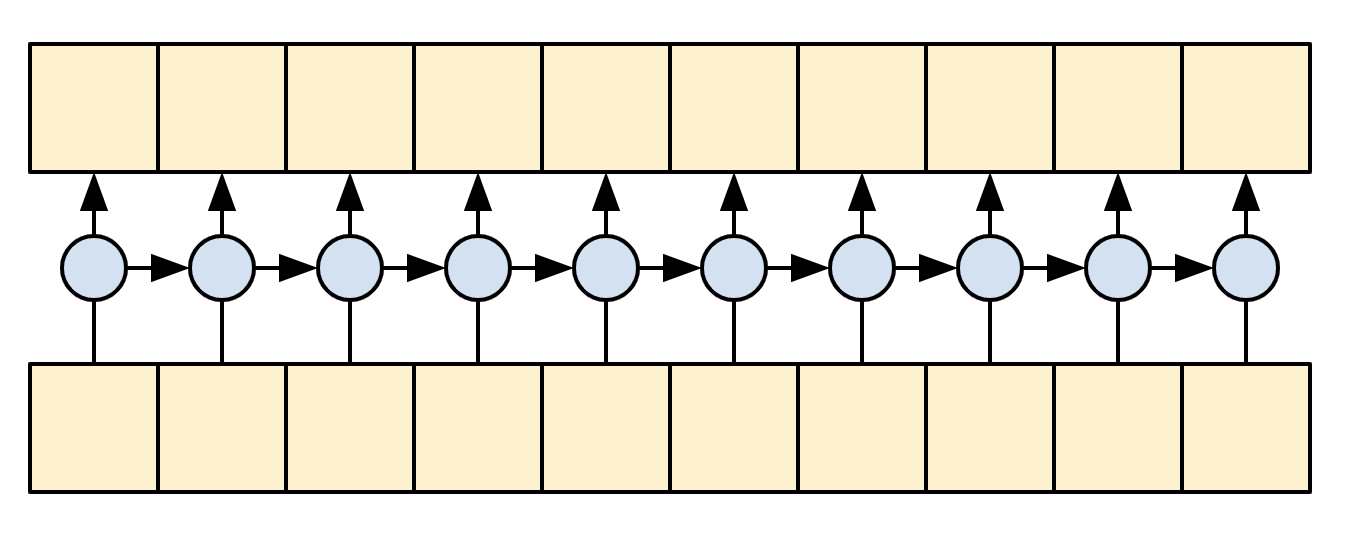

In [102]:
display.Image('imgs/decoderRNN.png')

In [103]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', 
            oov_token='[UNK]'
        )
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', 
            oov_token='[UNK]',
            invert=True
        )
        self.start_token = self.word_to_id('[SOS]')
        self.end_token = self.word_to_id('[EOS]')
        self.units = units
        
        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)
        
        # 2. The RNN keeps track of what's been generated so far
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)
        
        # 4. This fully connected layer produces the logits for each output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [104]:
@Decoder.add_method
def call(self,
         context, x, 
         state=None,
         return_state=False):
     shape_checker = ShapeChecker()
     shape_checker(x, 'batch t')
     shape_checker(context, 'batch s units')
     
     # 1. Lookup the embeddings
     x = self.embedding(x)
     shape_checker(x, 'batch t units')
     
     # 2. Process the target sequence.
     x, state = self.rnn(x, initial_state=state)
     shape_checker(x, 'batch t units')
     
     # 3. Use the RNN output as the query for the attention over the context.
     x = self.attention(x, context)
     self.last_attention_weights = self.attention.last_attention_weights
     shape_checker(x, 'batch t units')
     shape_checker(self.last_attention_weights, 'batch t s')
     
      # Step 4. Generate logit predictions for the next token.
     logits = self.output_layer(x)
     shape_checker(logits, 'batch t target_vocab_size')
     
     if return_state:
          return logits, state
     else:
          return logits

In [105]:
decoder = Decoder(target_text_processor, UNITS)

In [106]:
logits = decoder(ex_context, ex_tar_in)

In [107]:
print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 16, 256)
input target tokens shape: (batch, t) (64, 14)
logits shape shape: (batch, target_vocabulary_size) (64, 14, 5000)


In [108]:
word_to_id = tf.keras.layers.StringLookup(
            vocabulary=target_text_processor.get_vocabulary(),
            mask_token='', 
            oov_token='[UNK]'
        )

id_to_word = tf.keras.layers.StringLookup(
            vocabulary=target_text_processor.get_vocabulary(),
            mask_token='', 
            oov_token='[UNK]',
            invert=True
        )

In [109]:
batch_size = tf.shape(ex_context)[0]
print(batch_size.numpy())

start_tokens = tf.fill([batch_size, 1], word_to_id('[SOS]'))
print(start_tokens.shape)

done = tf.zeros([batch_size, 1], dtype=tf.bool)
print(done.shape)

embedding = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                      UNITS, mask_zero=True)

embedded = embedding(start_tokens)
print(embedded.shape)

64
(64, 1)
(64, 1)
(64, 1, 256)


In [110]:
tokens = []
temperature = 1.0
next_token = start_tokens
state = decoder.rnn.get_initial_state(embedded)[0]

for n in range(10):
    # Get logits and state using the decoder with initial state
    # logits size (batch_size, 1, vocab_size)
    logits, state = decoder(ex_context, next_token, state, return_state=True)
    
    if temperature == 0.0:
        # (The item with the maximum probability will be choosen)
        # Pick the item with the maximum probability
        next_token = tf.argmax(logits, axis=-1) 
    else:
        # Generate one samples according to the probabilistic distribution
        logits = logits[:, -1, :] / temperature
        next_token = tf.random.categorical(logits, num_samples=1)
        print(next_token[0])
    
    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == word_to_id('[EOS]'))
    
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    # Add the token to the output
    tokens.append(next_token) # tokens shape (batch_size, 1, t)

tf.Tensor([3781], shape=(1,), dtype=int64)
tf.Tensor([228], shape=(1,), dtype=int64)
tf.Tensor([1501], shape=(1,), dtype=int64)
tf.Tensor([2121], shape=(1,), dtype=int64)
tf.Tensor([4435], shape=(1,), dtype=int64)
tf.Tensor([2608], shape=(1,), dtype=int64)
tf.Tensor([30], shape=(1,), dtype=int64)
tf.Tensor([4333], shape=(1,), dtype=int64)
tf.Tensor([3052], shape=(1,), dtype=int64)
tf.Tensor([2847], shape=(1,), dtype=int64)


In [111]:
# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)
print(tokens)

tf.Tensor(
[[3781  228 1501 2121 4435 2608   30 4333 3052 2847]
 [ 516 1760 2614    5 2713 2422  884 2722  215 1838]
 [ 785 4654 1163 1062 4658 4201 2448  949 4989 3006]
 [3542 1215 2110 2031 3641 1164 4109 4324 1241 1780]
 [2245 3477 2082 1908 2522  715 4361 2002 1625 4379]
 [3184 2888 3574 2072 1663  406 1874  288 4889    0]
 [2595 4508 3008 2113  516 3934 4987 2467 1750 1293]
 [ 744 3379 1321 1423 3467  479 3158 1591 2691 1173]
 [3252 2117 1662   18 3650   66 4597 3228 2326 1051]
 [3204  189 3454  101  119 4264 3909 4058 1262 3076]
 [ 476 4868 3004 4618 4784 3370 4869 3526  465  558]
 [2729 1576 1984 1503 2595  668 3884 1207 3990 3614]
 [1475 2730  788 1952 1099 3117 4551 1194 1007 2322]
 [2098 1321 2829 2907 2711 2329 4540  921 3042 3208]
 [4223 3455 1690 4981  832 3268 1235 2251 3934 3747]
 [4583  898 1923 4739 2502 2663 1597 1557 1284 4899]
 [ 358 2140 1123 4801 3112  390 3131   14 2502 2019]
 [1352 4276 4411 3647 2840 1697 4358  608 4467 1143]
 [2415   45 2082 1606 2971 3107 397

In [112]:
# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch_size, t)

In [113]:
# convert the token back to a string
words = id_to_word(tokens)
result = tf.strings.reduce_join(words, axis=-1, separator=' ')
result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
result = tf.strings.regex_replace(result, ' *\[END\] *$', '')

In [114]:
print(result)

tf.Tensor(
[b'holds door refrigerator lecture realizes fierce his undergo material poison'
 b'free drug encouraged the model stubborn excuse latin mother kidding'
 b'attention deepest agreed spoken deadline debts pronounce necessary pretends research'
 b'disturbing paint prohibited sewing topic windows included valley enter spite'
 b'stabbed mall cab birth wolves heart switched build temperature steel'
 b'skating happiest century effort bathroom nobody round cold spitting '
 b'harvest materialistic repairing pointed free trips printed lit paying map'
 b'seeing tidy followed americans monkeys forget visible spain rabbit laugh'
 b'knocking oldest betrayed was thailand get fears occur switch painting'
 b'remote saw pathetic us ! behaves zealand nicer except gambling'
 b'mistake stretch sales earrings wool translating stressed facing breakfast surprised'
 b'honor cute lion prevented harvest cats beef calm shave youngest'
 b'jokes helpless paris deeply fall camping holes missing planning th

In [115]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [116]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature=0.0):
    logits, state = self(context, next_token, state, return_state=True)
    
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :] / temperature 
        next_token = tf.random.categorical(logits, num_samples=1)
    done = done | (next_token == self.end_token)
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
    return next_token, done, state

In [117]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [118]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'things hebrew bought ironed longest settle inspired briefcase salty forgiveness',
       b'exercises bang spy checked invest delay chatting remote fireplace stadium',
       b'visited hunger followed brains , teachers beating burst fastest alcoholic'],
      dtype=object)

# The translator model

In [119]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun
    
    def __init__(self, units, 
                 context_text_processor,
                 target_text_processor):
        super().__init__()
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)
        
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits  = self.decoder(context, x) 
    
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [120]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 14)
logits, shape: (batch, t, target_vocabulary_size) (64, 14, 5000)


# Train the model

### 1. Define loss function

In [121]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )
    loss = loss_fn(y_true, y_pred)
    
    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask
    
    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [122]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### 2. Configure the model for training

In [123]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [124]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [125]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 8s 52ms/step - loss: 8.5302 - masked_acc: 0.0000e+00 - masked_loss: 8.5302


{'loss': 8.530219078063965,
 'masked_acc': 0.0,
 'masked_loss': 8.530219078063965}

In [126]:
history = model.fit(
    train_ds.repeat(), 
    epochs=35,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/35
100/100 [==============================] - 25s 133ms/step - loss: 5.1064 - masked_acc: 0.2533 - masked_loss: 5.1064 - val_loss: 4.2113 - val_masked_acc: 0.3485 - val_masked_loss: 4.2113
Epoch 2/35
100/100 [==============================] - 15s 146ms/step - loss: 3.7965 - masked_acc: 0.3941 - masked_loss: 3.7965 - val_loss: 3.3933 - val_masked_acc: 0.4370 - val_masked_loss: 3.3933
Epoch 3/35
100/100 [==============================] - 13s 129ms/step - loss: 3.1653 - masked_acc: 0.4765 - masked_loss: 3.1653 - val_loss: 2.8557 - val_masked_acc: 0.5145 - val_masked_loss: 2.8557
Epoch 4/35
100/100 [==============================] - 13s 130ms/step - loss: 2.7574 - masked_acc: 0.5327 - masked_loss: 2.7574 - val_loss: 2.4329 - val_masked_acc: 0.5767 - val_masked_loss: 2.4329
Epoch 5/35
100/100 [==============================] - 15s 148ms/step - loss: 2.4355 - masked_acc: 0.5784 - masked_loss: 2.4355 - val_loss: 2.2630 - val_masked_acc: 0.5996 - val_masked_loss: 2.2630
Epoch 6/35
100/

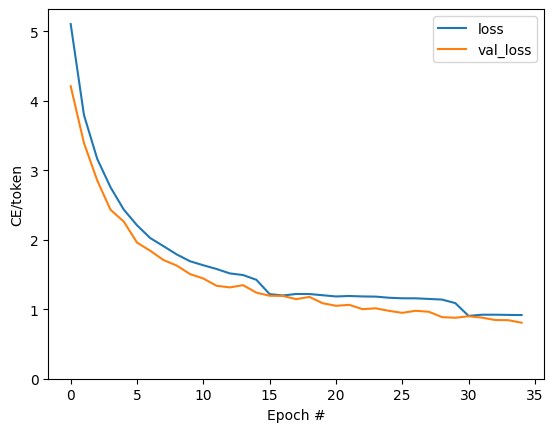

In [127]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

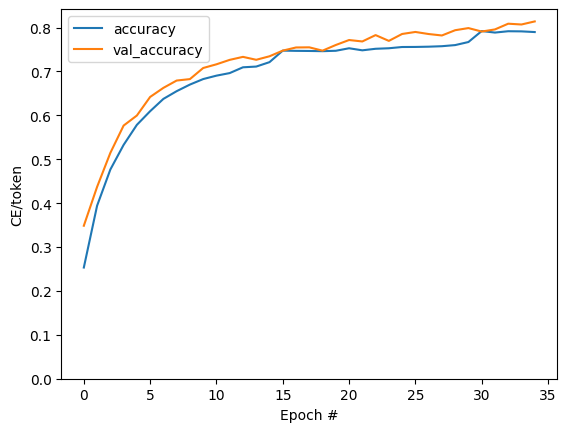

In [128]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Translate

In [133]:
@Translator.add_method
def translate(self, texts, *, max_length=50, tempature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

     # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)
    
    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)
    result = self.decoder.tokens_to_text(tokens)
    return result

In [136]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'are you still at home ? '

In [139]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = text_standardize(text)
  context = context.numpy().decode().split()

  output = text_standardize(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4212\1747423156.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4212\1747423156.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


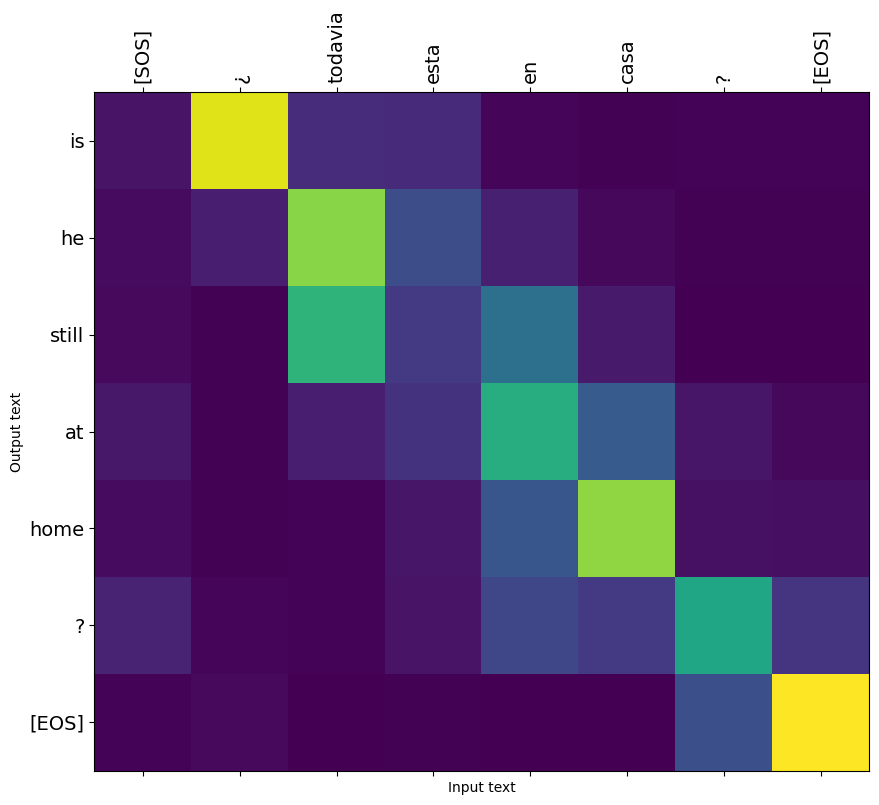

In [140]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4212\1747423156.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4212\1747423156.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


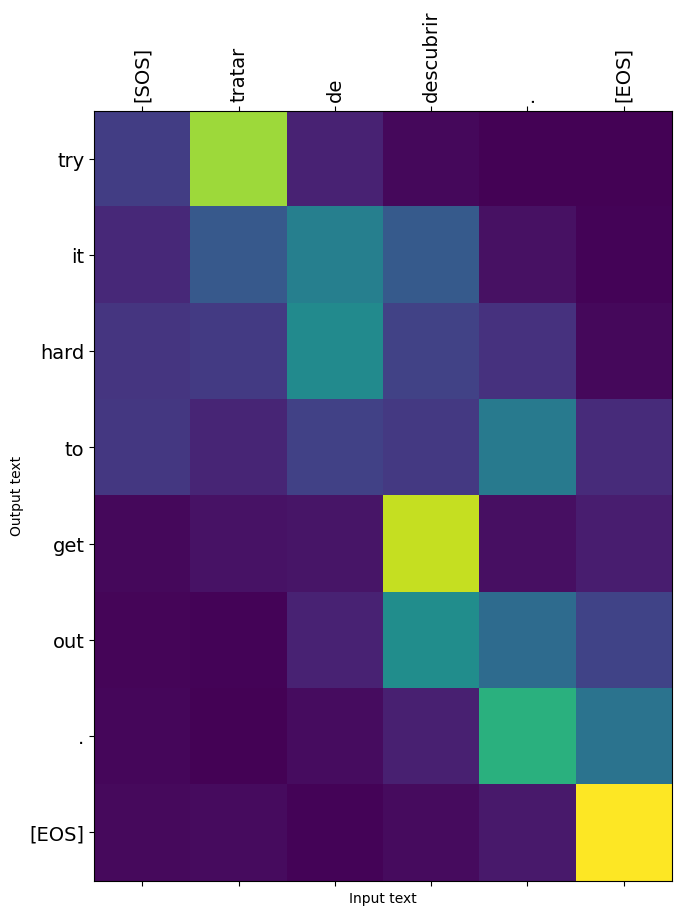

In [141]:
model.plot_attention('Tratar de descubrir.')

In [142]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 If you want to sound like a native speaker, you must be willing to
practice saying the same sentence over and over in the same way that
banjo players practice the same phrase over and over until they can
play it correctly and at the desired tempo.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4212\1747423156.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4212\1747423156.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


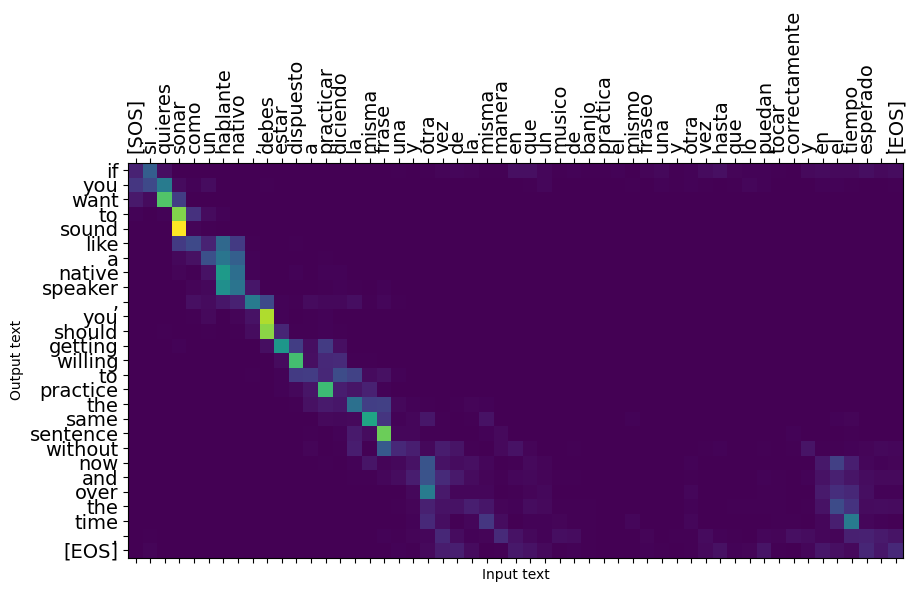

In [143]:
model.plot_attention(long_text)

# Export the model

In [144]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [145]:
export = Export(model)

In [146]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [147]:
_ = export.translate(tf.constant(inputs))

In [151]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
her bedroom is a mess .                                            

CPU times: total: 594 ms
Wall time: 347 ms


In [152]:
%%time
tf.saved_model.save(export, 'eng_spa_translator', 
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: eng_spa_translator\assets


INFO:tensorflow:Assets written to: eng_spa_translator\assets


CPU times: total: 1min 27s
Wall time: 1min 32s


In [153]:
reloaded_model = tf.saved_model.load('eng_spa_translator')

In [155]:
_ = reloaded_model.translate(tf.constant(inputs)) #warmup

In [157]:
%%time
result = reloaded_model.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .                                             
this is my life .                                             
her room is a fire .                                            

CPU times: total: 484 ms
Wall time: 398 ms


In [161]:
@Translator.add_method
def fast_translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # initialize the accumulator
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch t1')

    # Collect the generated tokens
    tokens = tokens.write(t, next_token)

    # if all the sequences are done, break
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch t1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

In [162]:
%%time
result = model.fast_translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
her room is a mess . 

CPU times: total: 328 ms
Wall time: 619 ms


In [165]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.fast_translate(inputs)

In [166]:
export = Export(model)

In [168]:
%%time
_ = export.translate(inputs)

CPU times: total: 5.31 s
Wall time: 6.61 s


In [169]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
her room is a mess . 

CPU times: total: 172 ms
Wall time: 411 ms


In [170]:
%%time
tf.saved_model.save(export, 'fast_eng_spa_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: fast_eng_spa_translator\assets


INFO:tensorflow:Assets written to: fast_eng_spa_translator\assets


CPU times: total: 36 s
Wall time: 38.5 s


In [171]:
%%time
reloaded = tf.saved_model.load('fast_eng_spa_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: total: 17 s
Wall time: 17.3 s


In [172]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its very cold here .  
this is my life .  
her room is a mess . 

CPU times: total: 141 ms
Wall time: 413 ms
